In [1]:
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar

In [2]:
data = pd.read_csv('cleaned_data/feature_set2.csv', index_col=[0,1])
data.index = data.index.set_levels(pd.to_datetime(data.index.levels[0]), level=0)

In [3]:
data.head()

perc_holding  mean_weight  median_weight  \
rebalance_date ticker                                             
2001-08-15     XOM         0.113537     0.377090       0.406151   
               T           0.109170     0.426623       0.277624   
               PEP         0.104803     0.195405       0.136823   
               PG          0.100437     0.102865       0.084891   
               CVX         0.100437     0.139776       0.058760   

                       perc_25_weight  perc_75_weight  last_21d_ret  \
rebalance_date ticker                                                 
2001-08-15     XOM           0.252700        0.474186     -0.029760   
               T             0.179817        0.848779     -0.001361   
               PEP           0.076296        0.269431     -0.013001   
               PG            0.043112        0.123043      0.042416   
               CVX           0.029206        0.138043      0.062061   

                       last_42d_ret  last_63d_ret  future_ret  
rebalance_date ticker                                          
2001-08-15     XOM        -0.068841     -0.075083   -0.062004  
               T           0.100584     -0.011926   -0.130074  
               PEP         0.052936      0.009618    0.106993  
               PG          0.164475      0.067450    0.089656  
               CVX        -0.046024     -0.031601   -0.054015

In [4]:
X = data.drop("future_ret", axis = 1)
Y = data["future_ret"]

train_X = X["2006-01-01":"2018-12-31"]
test_X = X["2019-01-01":]
train_Y = Y["2006-01-01":"2018-12-31"]
test_Y = Y["2019-01-01":]

# Handle outliers

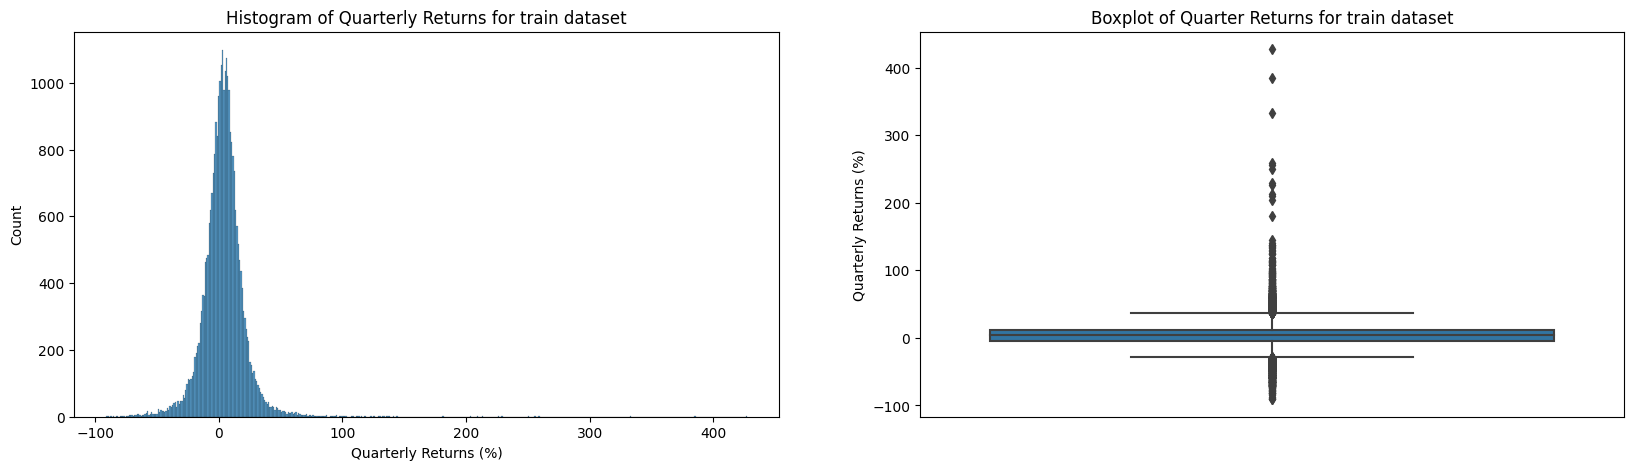

In [5]:
# Many outliers
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.histplot(train_Y * 100,ax=axs[0])
sns.boxplot(train_Y * 100,ax=axs[1])
axs[0].set_xlabel("Quarterly Returns (%)")
axs[0].set_title("Histogram of Quarterly Returns for train dataset")
axs[1].set_ylabel("Quarterly Returns (%)")
axs[1].set_xticks([])
axs[1].set_title("Boxplot of Quarter Returns for train dataset")
print()

In [6]:
# Cap outliers before log transformation
upper_Y = train_Y.mean() + 3 * train_Y.std()
lower_Y = train_Y.mean() - 3 * train_Y.std()
train_Y = train_Y.clip(lower=lower_Y,upper=upper_Y)

In [7]:
# Perform same transformation for test dataset
test_Y = test_Y.clip(lower=lower_Y,upper=upper_Y)
Y = Y.clip(lower=lower_Y, upper=upper_Y)

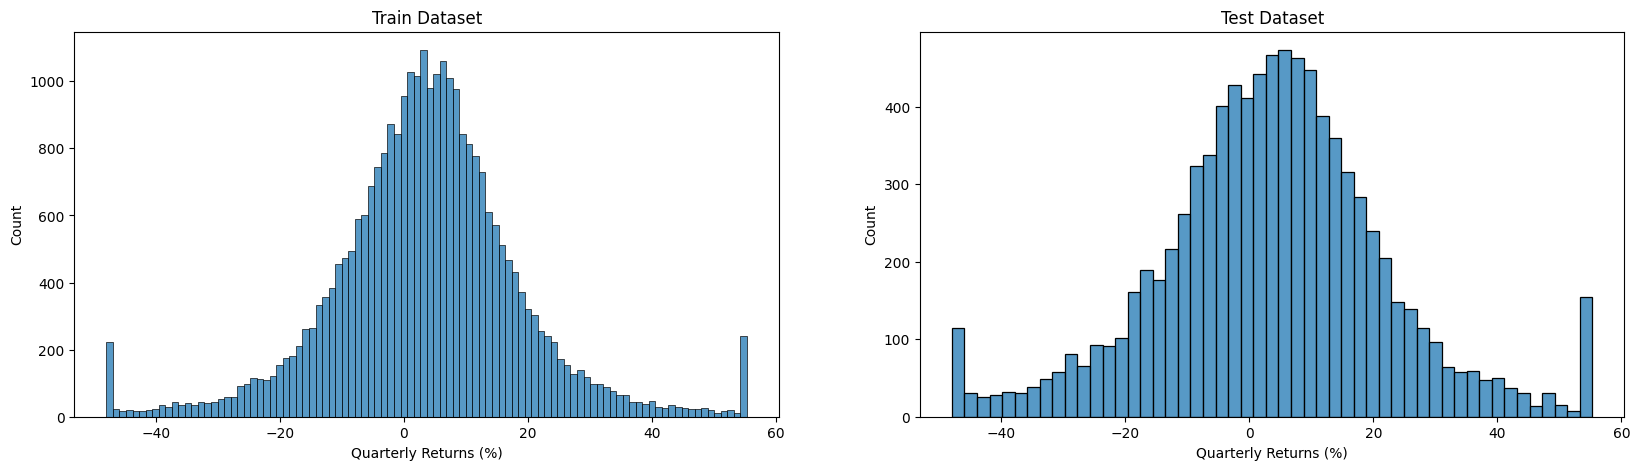

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.histplot(train_Y * 100, ax=axs[0])
axs[0].set_xlabel("Quarterly Returns (%)")
axs[0].set_title("Train Dataset")
sns.histplot(test_Y * 100, ax=axs[1])
axs[1].set_xlabel("Quarterly Returns (%)")
axs[1].set_title("Test Dataset")
print()

# EDA Features

In [9]:
train_X.describe()

,perc_holding,mean_weight,median_weight,perc_25_weight,perc_75_weight,last_21d_ret,last_42d_ret,last_63d_ret
count,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000
mean,0.013040,0.077818,0.032457,0.013246,0.087570,0.011504,0.020206,0.037942
std,0.015857,0.073284,0.061436,0.037451,0.107717,0.100361,0.149553,0.170917
min,0.000070,-0.011538,-0.000414,-0.000698,-0.000129,-0.727778,-0.841782,-0.899941
25%,0.003310,0.034226,0.006915,0.001986,0.026642,-0.039164,-0.047864,-0.044410
50%,0.007303,0.057611,0.014426,0.004589,0.054033,0.012081,0.022452,0.038311
75%,0.015587,0.097017,0.032826,0.011067,0.104526,0.061301,0.089408,0.118622
max,0.103982,0.948073,1.000000,0.948073,1.000000,1.568628,5.911111,4.098360


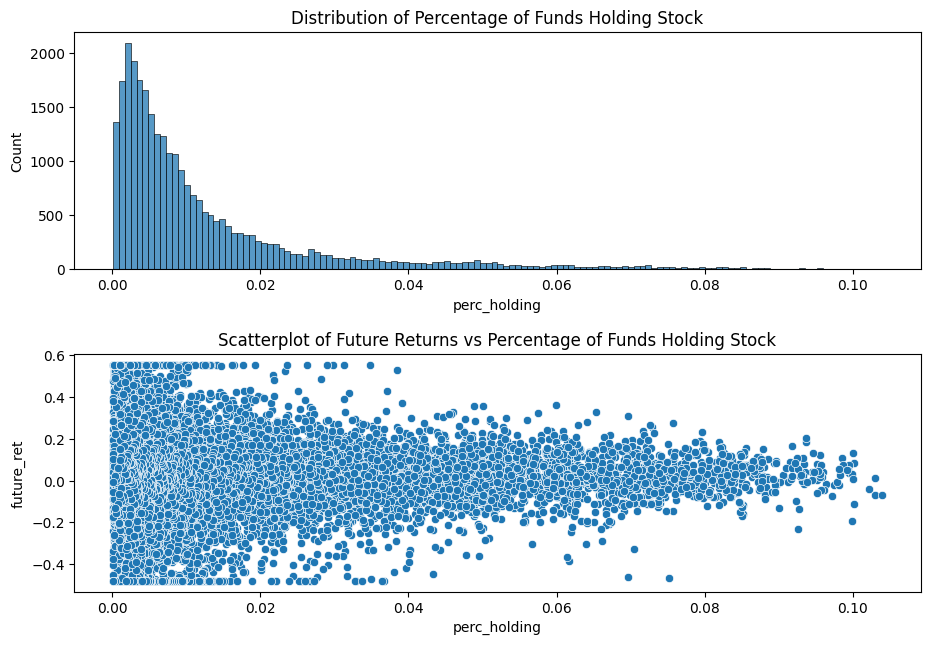

In [10]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_holding", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Percentage of Funds Holding Stock")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="perc_holding",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Percentage of Funds Holding Stock")
plt.show()

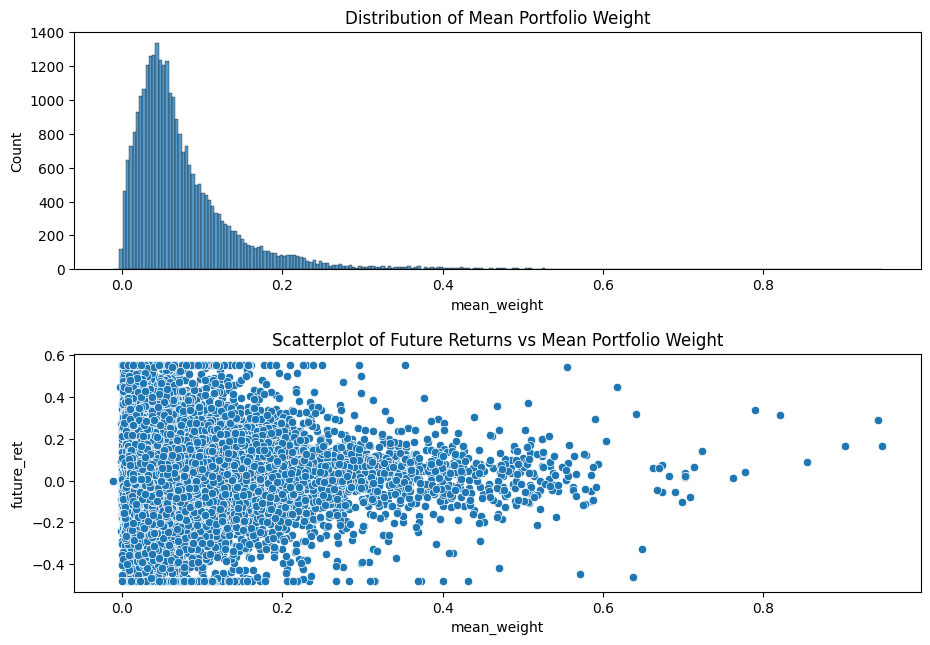

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="mean_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Mean Portfolio Weight")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="mean_weight",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Mean Portfolio Weight")
plt.show()

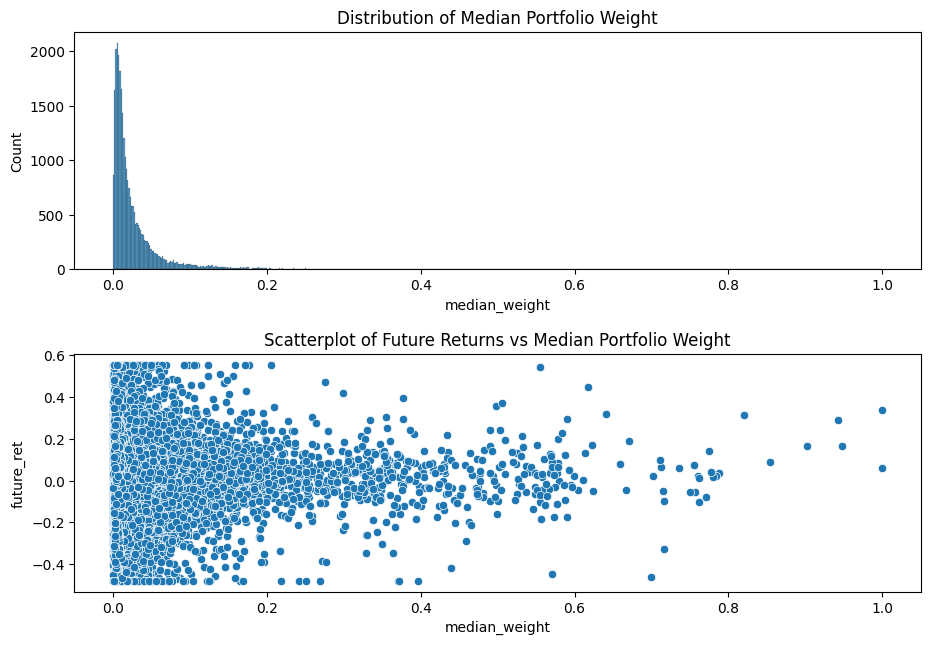

In [12]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="median_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Median Portfolio Weight")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="median_weight",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Median Portfolio Weight")
plt.show()

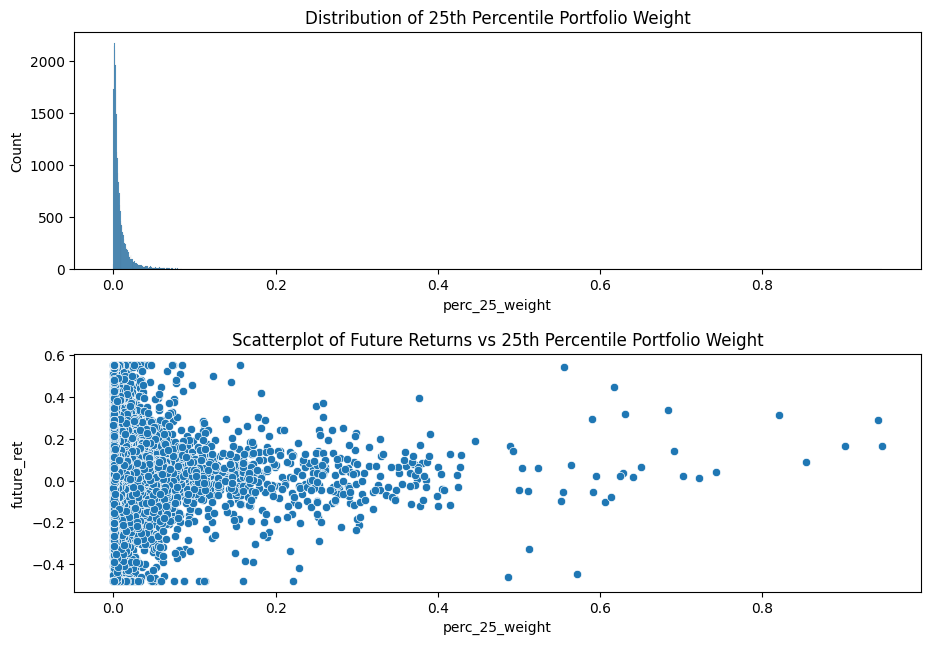

In [13]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_25_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of 25th Percentile Portfolio Weight")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="perc_25_weight",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs 25th Percentile Portfolio Weight")
plt.show()

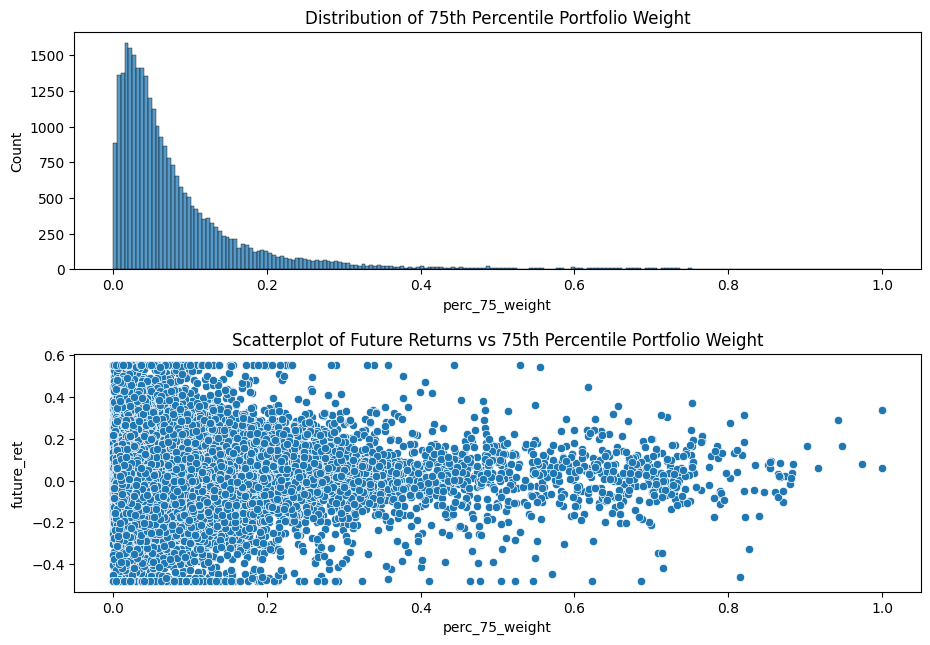

In [14]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_75_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of 75th Percentile Portfolio Weight")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="perc_75_weight",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs 75th Percentile Portfolio Weight")
plt.show()

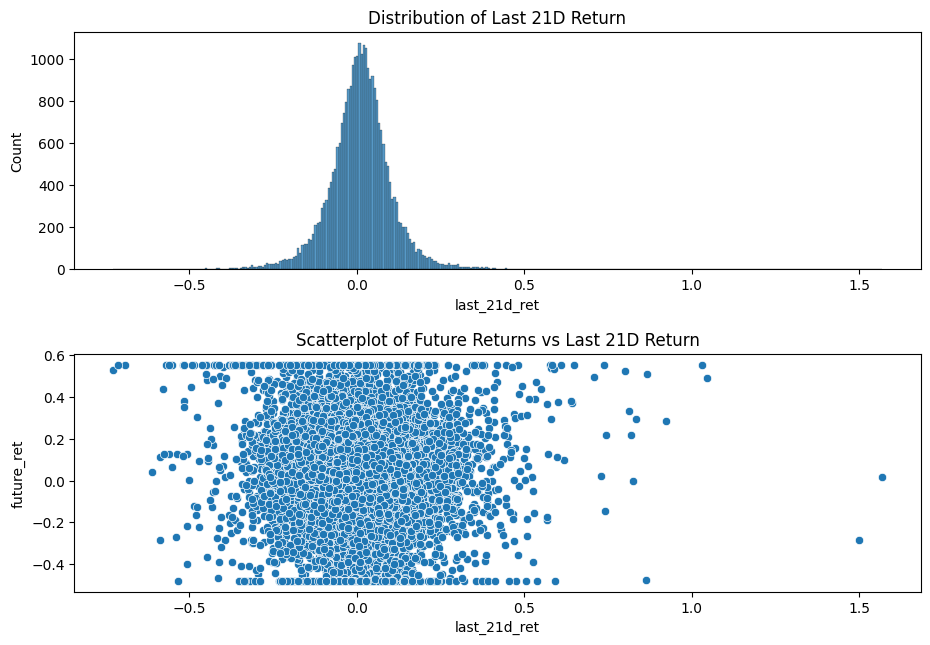

In [15]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="last_21d_ret", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Last 21D Return")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="last_21d_ret",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Last 21D Return")
plt.show()

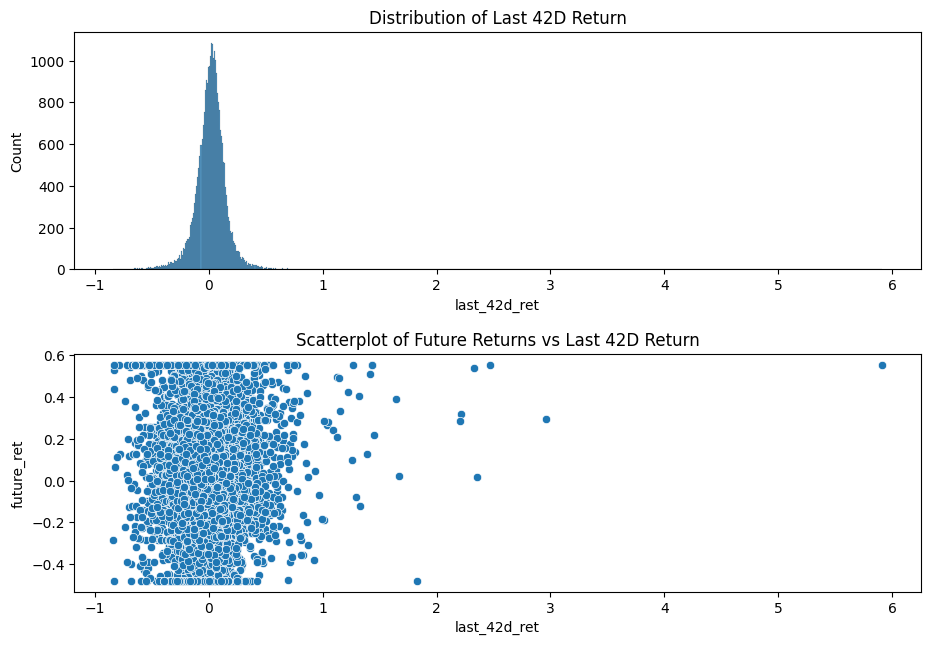

In [16]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="last_42d_ret", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Last 42D Return")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="last_42d_ret",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Last 42D Return")
plt.show()

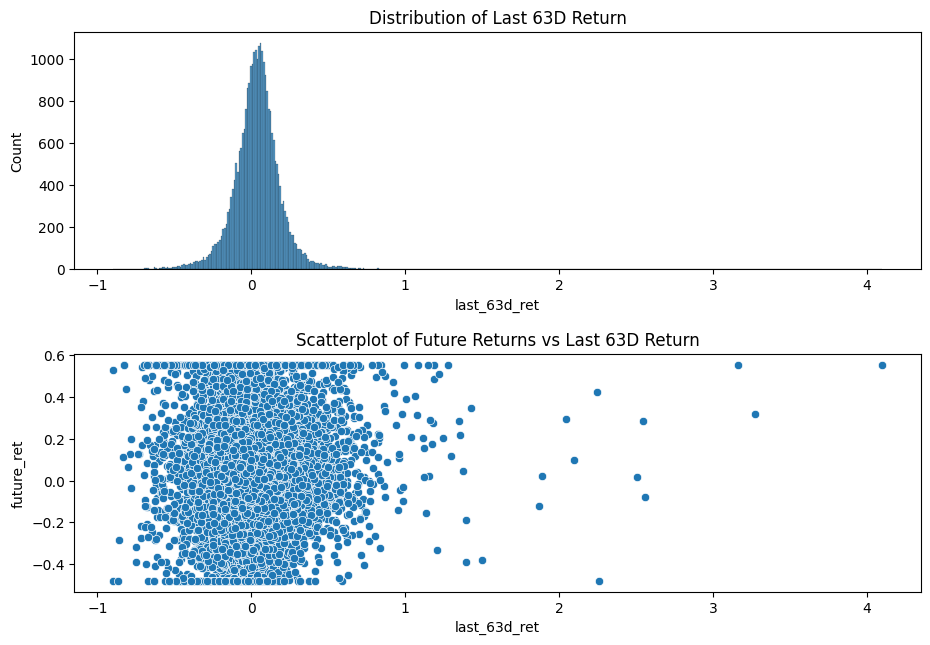

In [17]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="last_63d_ret", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Last 63D Return")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="last_63d_ret",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Last 63D Return")
plt.show()

<AxesSubplot: >

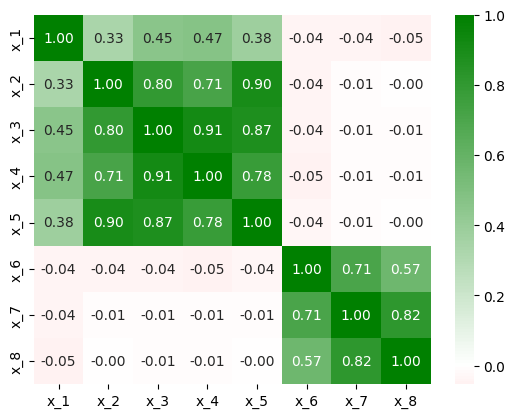

In [18]:
from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
tmp = train_X.copy()
tmp.columns = ["x_1",
               "x_2",
               "x_3",
               "x_4",
               "x_5",
               "x_6",
               "x_7", 
               "x_8"]
sns.heatmap(tmp.corr(method="spearman"), annot=True, cmap=cmap, center=0, fmt=".2f")

# Baseline model using last 63d (quarter) return as proxy for future return

In [19]:
pred_Y = Y.groupby('ticker').shift(1)
tmp = pd.DataFrame(Y)
tmp["pred"] = pred_Y
tmp = tmp.dropna()

In [20]:
train_tmp = tmp.loc["2006-01-01":"2018-12-31"]
test_tmp = tmp.loc["2019-01-01":]

bl_train_rmse = mean_squared_error(train_tmp.future_ret, train_tmp.pred, squared=False)
bl_test_rmse = mean_squared_error(test_tmp.future_ret, test_tmp.pred, squared=False)

print(f"Train RMSE: {bl_train_rmse}")
print(f"Test RMSE: {bl_test_rmse}")

Train RMSE: 0.21030269373128627
Test RMSE: 0.26600615314714765


In [21]:
print(f"Information coefficient (Pearson) of train set: {round(train_tmp.corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(train_tmp.corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.0616
Information coefficient (Spearman) of train set: 0.0344


In [22]:
print(f"Information coefficient (Pearson) of test set: {round(test_tmp.corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(test_tmp.corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: -0.02
Information coefficient (Spearman) of test set: -0.0127


# Linear Regression

In [23]:
lr_model = sm.OLS(train_Y,sm.add_constant(train_X))
results = lr_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             future_ret   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     40.28
Date:                Wed, 22 Mar 2023   Prob (F-statistic):           1.76e-64
Time:                        17:42:37   Log-Likelihood:                 13332.
No. Observations:               28913   AIC:                        -2.665e+04
Df Residuals:                   28904   BIC:                        -2.657e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0418      0.002     24.866      0.000       0.039       0.045
perc_holding      -0.3392      0.063     -5.372      0.000      -0.463      -0.215
mean_weight       -0.0842      0.040     -2.099      0.036      -0.163      -0.006
median_weight     -0.0896      0.057     -1.578      0.115      -0.201       0.022
perc_25_weight     0.2147      0.068      3.143      0.002       0.081       0.349
perc_75_weight     0.0202      0.028      0.720      0.472      -0.035       0.075
last_21d_ret      -0.0519      0.013     -3.970      0.000      -0.078      -0.026
last_42d_ret      -0.1030      0.013     -7.854      0.000      -0.129      -0.077
last_63d_ret       0.1483      0.010     14.950      0.000       0.129       0.168
==============================================================================
Omnibus:                     1179.909   Durbin-Watson:                   1.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3852.421
Skew:                          -0.021   Prob(JB):                         0.00
Kurtosis:                       4.788   Cond. No.                         98.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
lr_pred_train_Y = results.predict(sm.add_constant(train_X))
lr_pred_test_Y = results.predict(sm.add_constant(test_X))

In [25]:
lr_train_rmse = mean_squared_error(train_Y, lr_pred_train_Y, squared=False)
lr_test_rmse = mean_squared_error(test_Y, lr_pred_test_Y, squared=False)

print(f"Train RMSE: {lr_train_rmse}")
print(f"Test RMSE: {lr_test_rmse}")

Train RMSE: 0.15258514995165692
Test RMSE: 0.1922325206965541


In [26]:
print(f"Information coefficient (Pearson) of train set: {round(pd.concat([train_Y, lr_pred_train_Y], axis=1).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(pd.concat([train_Y, lr_pred_train_Y], axis=1).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.105
Information coefficient (Spearman) of train set: 0.0828


In [27]:
print(f"Information coefficient (Pearson) of test set: {round(pd.concat([test_Y, lr_pred_test_Y], axis=1).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(pd.concat([test_Y, lr_pred_test_Y], axis=1).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: -0.1061
Information coefficient (Spearman) of test set: -0.0603


# XGB

In [82]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=123)
xgb_model.fit(train_X, train_Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [83]:
xgb_pred_train_Y = xgb_model.predict(train_X)
xgb_pred_test_Y = xgb_model.predict(test_X)

In [84]:
xgb_train_rmse = mean_squared_error(train_Y, xgb_pred_train_Y, squared=False)
xgb_test_rmse = mean_squared_error(test_Y, xgb_pred_test_Y, squared=False)

print(f"Train RMSE: {xgb_train_rmse}")
print(f"Test RMSE: {xgb_test_rmse}")

Train RMSE: 0.12079855072983846
Test RMSE: 0.19254930054074396


In [85]:
print(f"Information coefficient (Pearson) of train set: {round(pd.DataFrame(train_Y).assign(pred=xgb_pred_train_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(pd.DataFrame(train_Y).assign(pred=xgb_pred_train_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.6655
Information coefficient (Spearman) of train set: 0.5284


In [86]:
print(f"Information coefficient (Pearson) of test set: {round(pd.DataFrame(test_Y).assign(pred=xgb_pred_test_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(pd.DataFrame(test_Y).assign(pred=xgb_pred_test_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: 0.082
Information coefficient (Spearman) of test set: 0.0675


# XGB - Hyperparameter Tuning + Cross validation

In [87]:
# For bayesian optimisation hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [88]:
def get_xgb_best_param(train_X, train_Y):
    curr_best_rounds = 0
    # Search range
    xgb_parameters = {
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        "eta": hp.uniform("eta", 0.1, 0.5),
        'gamma': hp.uniform ('gamma', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        "subsample": hp.uniform("subsample", 0.5, 1),
        'reg_alpha' : hp.choice('reg_alpha', [0.001, 0.01, 0.1, 1, 10, 100]),
    }

    def xgb_objective_func(space):
        params = {
            'colsample_bytree':space["colsample_bytree"],
            'max_depth':int(space["max_depth"]),
            'eta':space["eta"],
            'gamma':space["gamma"],
            'min_child_weight':int(space["min_child_weight"]),
            'subsample':space["subsample"],
            'reg_alpha':space["reg_alpha"],
            'objective':'reg:squarederror'
        }
        
        
        # Set num boost rounds to a high number and rely on early stopping round
        xgb_cv = xgb.cv(dtrain=xgb.DMatrix(train_X,train_Y), 
                        params=params, 
                        folds=KFold(3, shuffle=True),
                        num_boost_round=500, 
                        early_stopping_rounds=10, 
                        metrics="rmse", 
                        as_pandas=True, 
                        seed=123)
        min_rmse = xgb_cv['test-rmse-mean'].min()
        nonlocal curr_best_rounds
        curr_best_rounds = xgb_cv['test-rmse-mean'].argmin()
        return {'loss': min_rmse, 'status': STATUS_OK}

    trials = Trials()

    xgb_best_param = fmin(fn = xgb_objective_func,
                      space = xgb_parameters,
                      algo = tpe.suggest,
                      max_evals = 100,
                      trials = trials)      
    xgb_best_param["n_estimators"] = curr_best_rounds
    
    return xgb_best_param

In [89]:
xgb_best_param = get_xgb_best_param(train_X,train_Y)

100%|██████████| 100/100 [02:34<00:00,  1.54s/trial, best loss: 0.15164854483336973]


In [90]:
xgb_best_param

{'colsample_bytree': 0.5924169908820669,
 'eta': 0.10307626378091989,
 'gamma': 0.26177366231060284,
 'max_depth': 6.0,
 'min_child_weight': 5.0,
 'reg_alpha': 1,
 'subsample': 0.9257932541973513,
 'n_estimators': 64}

In [91]:
tuned_xgb_model = xgb.XGBRegressor(
                      colsample_bytree = xgb_best_param["colsample_bytree"], 
                      max_depth=int(xgb_best_param["max_depth"]),
                      eta=xgb_best_param["eta"],
                      gamma=xgb_best_param["gamma"],
                      min_child_weight=int(xgb_best_param["min_child_weight"]),
                      subsample=xgb_best_param["subsample"],
                      reg_alpha=xgb_best_param["reg_alpha"],
                      verbosity=1,
                      eval_metric="rmse",
                      n_estimators=xgb_best_param["n_estimators"],
                      seed=123)
tuned_xgb_model.fit(train_X, train_Y)    

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5924169908820669, early_stopping_rounds=None,
             enable_categorical=False, eta=0.10307626378091989,
             eval_metric='rmse', feature_types=None, gamma=0.26177366231060284,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=64, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [92]:
tuned_xgb_pred_train_Y = tuned_xgb_model.predict(train_X)
tuned_xgb_pred_test_Y = tuned_xgb_model.predict(test_X)

In [93]:
tuned_xgb_train_rmse = mean_squared_error(train_Y, tuned_xgb_pred_train_Y, squared=False)
tuned_xgb_test_rmse = mean_squared_error(test_Y, tuned_xgb_pred_test_Y, squared=False)

print(f"Train RMSE: {tuned_xgb_train_rmse}")
print(f"Test RMSE: {tuned_xgb_test_rmse}")

Train RMSE: 0.14854783027772167
Test RMSE: 0.18731786714871593


In [94]:
print(f"Information coefficient (Pearson) of train set: {round(pd.DataFrame(train_Y).assign(pred=tuned_xgb_pred_train_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(pd.DataFrame(train_Y).assign(pred=tuned_xgb_pred_train_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.2904
Information coefficient (Spearman) of train set: 0.1855


In [95]:
print(f"Information coefficient (Pearson) of test set: {round(pd.DataFrame(test_Y).assign(pred=tuned_xgb_pred_test_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(pd.DataFrame(test_Y).assign(pred=tuned_xgb_pred_test_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: 0.0566
Information coefficient (Spearman) of test set: 0.0457
